In [1]:
import sys
from functools import partial
from zipfile import ZipFile
import pandas as pd
sys.path.append('../src')
%matplotlib inline

# Your contact details

In [37]:
# If you're having problem importing this file, copy and paste the contents of "uatt.py" in this cell instead
# of the import statement
from uatt import submit
my_submit = partial(submit, "nati yannay", "elta", "natiy4@gmail.com", "0528843480")

# Read data

In [3]:
data = []
with ZipFile("../data/data.zip") as z:
    for fname in z.namelist():
        if not fname.endswith('.txt') or not fname.startswith('data'):
            continue
        content = z.read(fname).decode('utf8')
        label, idx = fname[5:-4].split('-', 1)
        data.append((idx,label,content,))
df_train = pd.DataFrame(data, columns=("id", "label", "content"))
df_train.sample(10)

,id,label,content
209,39760,bylaws,Exhibit 3.2 \n\n\n\nof \n\nNEWPAGE CORPORATION...
1531,10540,employment,Exhibit 10.40 \n\n\n\nTHIS EMPLOYMENT AGREEMEN...
191,39580,bylaws,"EXHIBIT 3.2\n\n\n\nOF\n\nSCHAWK, INC.*\n\nARTI..."
3466,28500,rsu,\n\n\n \n\n\nExhibit 10.2\n\n \n\n\nCOMPUT...
724,02470,credit,* * *\n\n* * *\n\nExhibit 10.2 \n\n\n \n\n\n...
3624,30080,rsu,Exhibit 10.5 \n\n\n\nIssued Pursuant to the \n...
1791,13140,employment,Exhibit 10.1\n\n\n\nThis EMPLOYMENT AGREEMENT ...
3813,31970,rsu,\nQuickLinks \-- Click here to rapidly navig...
1938,14610,employment,Exhibit 10.2 \n\n\n\nTHIS AGREEMENT is made as...
317,40840,bylaws,EXHIBIT 3.4 \n\n\n\nB Y — L A W S\n\n(As amend...


In [4]:
data = []
with ZipFile("../data/test_data.zip") as z:
    for fname in z.namelist():
        content = z.read(fname).decode('utf8')
        if not fname.endswith('.txt') or not fname.startswith('test'):
            continue
        idx = fname[5:-4]
        data.append((idx,content,))
df_test = pd.DataFrame(data, columns=("id", "content"))
df_test.sample(10)

,id,content
543,rovuz,Exhibit 10.30 \n\nFORM OF \n\n\n\nPURSUANT TO ...
821,zyfno,Exhibit 10.1 \n\n\n\nEmployment Agreement date...
643,usary,Exhibit 10.2 \n\nExecution Copy \n\n\n\nThis E...
208,gslpc,Exhibit 10.19\n\nFRANCESCA’S HOLDINGS CORPORAT...
535,rhswc,Second Amendment To \n\nAmended and Restated\n...
43,bofsm,"Exhibit 10.86\n\n\n\nAgreement, made as of Jan..."
733,xupyc,Exhibit 10.13 \n\n\n\nTHIS EMPLOYMENT AGREEMEN...
517,qnmpo,"\n\n\n\n\n \n\n\nStock Purchase Agreement, ..."
509,qifwz,Exhibit 10.17\n\n\n\nTHIS EMPLOYMENT AGREEMENT...
669,vqxis,"EXHIBIT 10.1\n\nFLASR, INC.\n\nSERIES A CONVER..."


# Plot distribution of labels

<AxesSubplot:>

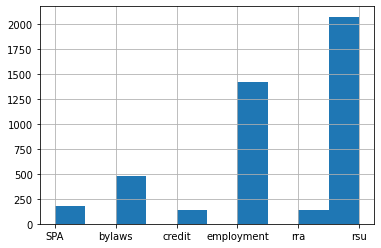

In [29]:
my_tags = df_train.label.unique()

df_train["label"].hist()

## model claculation 

In [15]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_train, test_size=0.1, random_state=42)

### baseline

In [17]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords

nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natiy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [27]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['content'])
    predictions = classifier.predict(data_features)
    target = data['label']
    evaluate_prediction(predictions, target)

Baseline: bag of words, n-grams, tf-idf
Let's start with some simple baselines before diving into more advanced methods.

Bag of words
The simplest document feature is just a count of each word occurrence in a document.

We remove stop-words and use NLTK tokenizer then limit our vocabulary to 3k most frequent words.

In [21]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [22]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['content'])

Wall time: 52.3 s


Multi-modal logistic regression is a simple white-box classifier. We will use either logistic regression or KNN throughout this tutorial.



In [24]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['label'])

C:\Users\natiy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
count_vectorizer.get_feature_names()[80:90]


C:\Users\natiy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['18.', '180', '18\\', '19', '19.', '1933', '1934', '1986', '1998', '1999']

accuracy 0.9841986455981941
confusion matrix
 [[ 25   0   0   1   0   0]
 [  0  45   0   0   0   0]
 [  0   0  14   1   0   0]
 [  0   0   0 139   0   0]
 [  1   0   0   0  12   0]
 [  2   0   0   2   0 201]]
(row=expected, col=predicted)


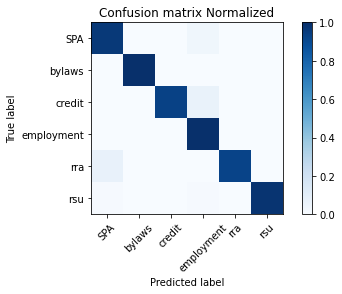

In [30]:
predict(count_vectorizer, logreg, test_data)


# Submit
## Sample submission 1: "All RSU"

In [34]:
def makepredict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['content'])
    predictions = classifier.predict(data_features)
    
    return predictions


In [36]:
df_test["label"] = makepredict(count_vectorizer, logreg, df_test)

In [38]:
my_submit

functools.partial(<function submit at 0x000001B878545F70>, 'nati yannay', 'elta', 'natiy4@gmail.com', '0528843480')

In [40]:
# for all documents
#df_test["label"] = "rsu"
submission = dict(df_test[["id","label"]].values)
#submission name must be unique
submission_name = "nati lr-bow"
my_submit(submission_name, submission)


0.95620437956204

## Sample submission 2: Submission by string search


In [7]:
df_test["label"] = "rsu"
df_test.loc[df_test["content"].str.contains("EMPLOYMENT"),"label"] = 'employment'
df_test.loc[df_test["content"].str.contains("CREDIT"),"label"] = 'credit'
df_test.loc[df_test["content"].str.contains("BYLAWS"),"label"] = 'bylaws'
df_test.loc[df_test["content"].str.contains("REGISTRAR"),"label"] = 'rra'
submission = dict(df_test[["id","label"]].values)

submission_name = "uri_string_search"
my_submit(submission_name, submission)

0.65085158150852

# See how you rank
Leaderboard is available at:
https://goren.ml/uattcontract

Accuracy of **90%** and above is required to pass the test

## Leaderboard not refreshing ?
try adding a random suffix to it, like this one:

In [8]:
import random, string
from IPython.display import HTML
rand_str = lambda: "".join(random.sample(string.ascii_letters,7))
HTML('<a href="https://goren.ml/uattcontract/?{k}={v}" target="_blank">Go to Leaderboard</a>'.format(k=rand_str(),v=rand_str()))